##### Figure S17: pi and Tajima's D in the USA specimens, split out by geographic origin as in Lee et al. 2019

In [1]:
from collections import defaultdict
import dask.array as da
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd

import allel

import ingenos

In [2]:
base_path = "/overflow/dschridelab/users/rrlove/aedes/"
md_path = f"{base_path}metadata/"
results_path = f"{base_path}results/"
zarr_path = "/proj/dschridelab/rrlove/aedes/vcf/filtered_110122/"

In [3]:
chroms = ["AaegL5_1", "AaegL5_2", "AaegL5_3"]
countries = ["Brazil", "Colombia", "USA", "Kenya", "Senegal", "Gabon"]

##### read in the data

In [4]:
def return_data(zarr_path, data_type, data_name):
    
    fetch_str = f"{data_type}/{data_name}" 
    
    return da.from_zarr(zarr_path, component=fetch_str)

In [5]:
chroms_dict = defaultdict(dict)

for chrom in chroms:
    
    temp_in_path = zarr_path + chrom

    chroms_dict[chrom]["pos"] = return_data(temp_in_path, "variants", "POS")
    chroms_dict[chrom]["chrom"] = return_data(temp_in_path, "variants", "CHROM")
    chroms_dict[chrom]["ref"] = return_data(temp_in_path, "variants", "REF")
    chroms_dict[chrom]["alt"] = return_data(temp_in_path, "variants", "ALT")
    chroms_dict[chrom]["ac"] = return_data(temp_in_path, "variants", "AC")
    chroms_dict[chrom]["qd"] = return_data(temp_in_path, "variants", "QD")
    chroms_dict[chrom]["mq"] = return_data(temp_in_path, "variants", "MQ")
    chroms_dict[chrom]["fs"] = return_data(temp_in_path, "variants", "FS")
    chroms_dict[chrom]["mqrs"] = return_data(temp_in_path, "variants", "MQRankSum")
    chroms_dict[chrom]["rprs"] = return_data(temp_in_path, "variants", "ReadPosRankSum")
    chroms_dict[chrom]["sor"] = return_data(temp_in_path, "variants", "SOR")
    chroms_dict[chrom]["is_snp"] = return_data(temp_in_path, "variants", "is_snp")
    chroms_dict[chrom]["numalt"] = return_data(temp_in_path, "variants", "numalt")
    chroms_dict[chrom]["filter_pass"] = return_data(temp_in_path, "variants", "FILTER_PASS")

    chroms_dict[chrom]["gt"] = return_data(temp_in_path, "calldata", "GT")
    chroms_dict[chrom]["gq"] = return_data(temp_in_path, "calldata", "GQ")
    chroms_dict[chrom]["ad"] = return_data(temp_in_path, "calldata", "AD")
    chroms_dict[chrom]["pl"] = return_data(temp_in_path, "calldata", "PL")
    chroms_dict[chrom]["dp"] = return_data(temp_in_path, "calldata", "DP")
    
    print(chrom, chroms_dict[chrom]["gt"].shape)
    
samples = da.from_zarr(temp_in_path, component="samples")

AaegL5_1 (18443972, 131, 2)
AaegL5_2 (32930875, 131, 2)
AaegL5_3 (27660249, 131, 2)


In [6]:
np.sum([chroms_dict[chrom]["gt"].shape[0] for chrom in chroms])

79035096

##### read in the metadata

In [7]:
md = pd.read_table(
    md_path + "whole_sample_sorted_country.031522.csv", 
    sep="\t",)

md["locality"] = md["location"].str.split(": ", expand=True)[1]

md.head()

,sample_id,sample_short,location,sex,batch,sample_id_cat,country,locality
0,FEMALE_1-F1_CGCATGAT-TCAGGCTT_S1,FEMALE_1,Colombia: Rio Claro,F,1,FEMALE_1-F1_CGCATGAT-TCAGGCTT_S1,Colombia,Rio Claro
1,FEMALE_10-F10_GTGCCATA-ACTAGGAG_S2,FEMALE_10,Colombia: Rio Claro,F,1,FEMALE_10-F10_GTGCCATA-ACTAGGAG_S2,Colombia,Rio Claro
2,FEMALE_11-F11_CGTTGCAA-CGCTCTAT_S3,FEMALE_11,Colombia: Rio Claro,F,1,FEMALE_11-F11_CGTTGCAA-CGCTCTAT_S3,Colombia,Rio Claro
3,FEMALE_12-F12_TGAAGACG-TGGCATGT_S4,FEMALE_12,Colombia: Rio Claro,F,1,FEMALE_12-F12_TGAAGACG-TGGCATGT_S4,Colombia,Rio Claro
4,FEMALE_14-F14_ACGTTCAG-GCACAACT_S6,FEMALE_14,Colombia: Rio Claro,F,1,FEMALE_14-F14_ACGTTCAG-GCACAACT_S6,Colombia,Rio Claro


In [8]:
to_drop = np.loadtxt(md_path + "close_kin_removed_new_dataset.txt",
                    dtype=str)

to_drop_bool = (~(md["sample_short"].isin(to_drop)).values)

np.sum(to_drop_bool)

123

In [9]:
md_filtered = md.loc[to_drop_bool]

md_filtered.shape

(123, 8)

In [10]:
country_bools = {}

for country in md_filtered["country"].unique():
    
    country_bools[country] = (md_filtered["country"] == country).values
    
country_bools.keys()

dict_keys(['Colombia', 'Kenya', 'Senegal', 'Gabon', 'Brazil', 'USA'])

In [11]:
snps = [316080722, 316014588, 315999297, 315983763, 315939224]

chrom = "AaegL5_3"

region_flt = ((chroms_dict[chrom]["pos"] > 310000000) & \
            (chroms_dict[chrom]["pos"] < 320000000))

np.sum(region_flt).compute()

641298

In [12]:
region_gt = allel.GenotypeArray(chroms_dict[chrom]["gt"]).subset(sel0 = region_flt, 
                                                          sel1 = to_drop_bool)

region_gt.shape

(641298, 123, 2)

In [13]:
pos = chroms_dict[chrom]["pos"][region_flt].compute()

pos.shape

(641298,)

In [14]:
vgsc_pi_dict = {}

vgsc_pi_dict["Brazil"] = \
allel.windowed_diversity(chroms_dict[chrom]["pos"][region_flt], 
                         region_gt.subset(sel1 = country_bools["Brazil"]).count_alleles(), 
                         size=500000, step=50000)

vgsc_pi_dict["Colombia"] = \
allel.windowed_diversity(chroms_dict[chrom]["pos"][region_flt], 
                         region_gt.subset(sel1 = country_bools["Colombia"]).count_alleles(), 
                         size=500000, step=50000)

In [15]:
vgsc_d_dict = {}

vgsc_d_dict["Brazil"] = \
allel.windowed_tajima_d(chroms_dict[chrom]["pos"][region_flt], 
                         region_gt.subset(sel1 = country_bools["Brazil"]).count_alleles(), 
                         size=500000, step=50000)

vgsc_d_dict["Colombia"] = \
allel.windowed_tajima_d(chroms_dict[chrom]["pos"][region_flt], 
                         region_gt.subset(sel1 = country_bools["Colombia"]).count_alleles(), 
                         size=500000, step=50000)

for place in md_filtered.loc[((md_filtered["country"] == "Brazil") |\
                 (md_filtered["country"] == "Colombia") |\
                 (md_filtered["country"] == "USA")), "locality"].unique():
    
    flt = (md_filtered["locality"] == place).values
    
    print(place, np.sum(flt))
    
    vgsc_d_dict[place] = \
    allel.windowed_tajima_d(chroms_dict[chrom]["pos"][region_flt], 
                         region_gt.subset(sel1 = flt).count_alleles(), 
                         size=500000, step=50000)

Rio Claro 22
Cali 10
Santarem 16
Fresno 2
Madera 2
Menlo Park 2
Key West\, FL 1


/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/stats/diversity.py:1068: RuntimeWarning: invalid value encountered in double_scalars
  wD = d / d_stdev
/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/stats/diversity.py:1068: RuntimeWarning: invalid value encountered in double_scalars
  wD = d / d_stdev


Vero Beach\, FL 1
Exeter 2
Commerce 1
Mission Viejo 2


/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/stats/diversity.py:1068: RuntimeWarning: invalid value encountered in double_scalars
  wD = d / d_stdev


Garden Grove 2
Brawley 1


/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/stats/diversity.py:1068: RuntimeWarning: invalid value encountered in double_scalars
  wD = d / d_stdev


San Diego 2
Clovis 7
Sanger 1


/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/stats/diversity.py:1068: RuntimeWarning: invalid value encountered in double_scalars
  wD = d / d_stdev


##### populations with more than one specimen: Rio Claro, Cali, Santarem, Fresno, Madera, Menlo Park, Exeter, Mission Viejo, San Diego, Clovis

In [16]:
CA_1 = ["Menlo Park", "Madera", "Fresno"] 
CA_2 = ["Clovis", "Sanger"] 
CA_3 = ["Garden Grove", "Mission Viejo", "Brawley", "San Diego", "Exeter"]

In [17]:
vgsc_pi_dict["CA_1"] = \
allel.windowed_diversity(chroms_dict[chrom]["pos"][region_flt], 
                         region_gt.subset(sel1 = md_filtered["locality"].isin(CA_1)).count_alleles(), 
                         size=500000, step=50000)

vgsc_pi_dict["CA_2"] = \
allel.windowed_diversity(chroms_dict[chrom]["pos"][region_flt], 
                         region_gt.subset(sel1 = md_filtered["locality"].isin(CA_2)).count_alleles(), 
                         size=500000, step=50000)

vgsc_pi_dict["CA_3"] = \
allel.windowed_diversity(chroms_dict[chrom]["pos"][region_flt], 
                         region_gt.subset(sel1 = md_filtered["locality"].isin(CA_3)).count_alleles(), 
                         size=500000, step=50000)

In [18]:
vgsc_d_dict["CA_1"] = \
allel.windowed_tajima_d(chroms_dict[chrom]["pos"][region_flt], 
                         region_gt.subset(sel1 = md_filtered["locality"].isin(CA_1)).count_alleles(), 
                         size=500000, step=50000)

vgsc_d_dict["CA_2"] = \
allel.windowed_tajima_d(chroms_dict[chrom]["pos"][region_flt], 
                         region_gt.subset(sel1 = md_filtered["locality"].isin(CA_2)).count_alleles(), 
                         size=500000, step=50000)

vgsc_d_dict["CA_3"] = \
allel.windowed_tajima_d(chroms_dict[chrom]["pos"][region_flt], 
                         region_gt.subset(sel1 = md_filtered["locality"].isin(CA_3)).count_alleles(), 
                         size=500000, step=50000)

In [19]:
outString = ingenos.make_date_stamp(results_path + \
                                    "Vssc/Vgsc_pi_D_Americas", ".pdf")

outString

'/overflow/dschridelab/users/rrlove/aedes/results/Vssc/Vgsc_pi_D_Americas.021023.pdf'

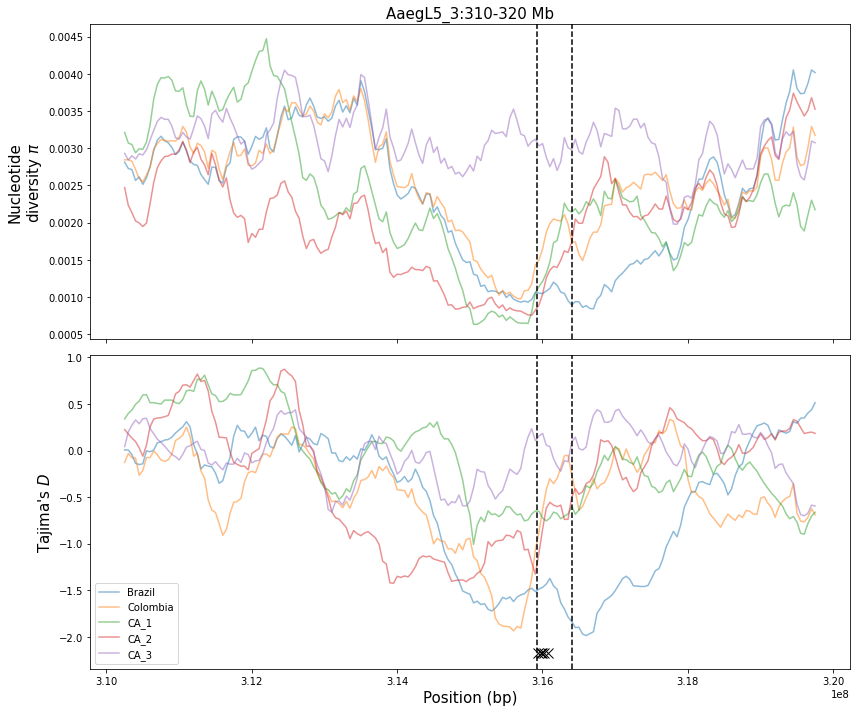

In [20]:
start, end = (315926360, 316405639)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex="col")

for pop in ["Brazil", "Colombia", "CA_1", "CA_2", "CA_3"]:
    
    out, windows, _, _ = vgsc_pi_dict[pop]

    axes[0].plot(np.mean(windows, axis=1), out, label = pop, alpha = 0.5)
    
    out, windows, _ = vgsc_d_dict[pop]
    
    axes[1].plot(np.mean(windows, axis=1), out, label = pop, alpha = 0.5)

axes[0].set_ylabel("Nucleotide\n" + r"diversity $\pi$", fontsize=15)
axes[0].set_title("AaegL5_3:310-320 Mb", fontsize=15)

axes[1].set_ylabel(r"Tajima's $D$", fontsize=15)
axes[1].set_xlabel("Position (bp)", size=15)
axes[1].legend()

for ax in axes.flatten():
    
    ax.axvline(x=start, linestyle = "--", color = "black")
    ax.axvline(x=end, linestyle = "--", color = "black")
    
trans = transforms.blended_transform_factory(axes[1].transData, axes[1].transAxes)

for snp in [315939224, 315983763, 315999297, 316014588, 316080722]:

    axes[1].plot(snp, 0.05, marker="x", markersize=10, color="black", 
                 transform=trans, linestyle=" ")

lower_bound = axes[1].get_ylim()[0]
axes[1].set_ylim(bottom=lower_bound*1.1)

plt.tight_layout()

#plt.savefig(outString, bbox_inches="tight")